In [1]:
import gzip
import numpy
import scipy.optimize
import matplotlib.pyplot as plt
from collections import defaultdict

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before
allRatings = []
userRatings = defaultdict(list)
data = list(readGz("Assignment1/HW3/assignment1/train.json.gz"))

In [2]:
### Gradient descent ###

# Objective
def f(theta, X, y, lam):
  theta = numpy.matrix(theta).T
  X = numpy.matrix(X)
  y = numpy.matrix(y).T
  diff = X*theta - y
  diffSq = diff.T*diff
  diffSqReg = diffSq / len(X) + lam*(theta.T*theta)
  #print "offset =", diffSqReg.flatten().tolist()
  return diffSqReg.flatten().tolist()[0]

# Derivative
def fprime(theta, X, y, lam):
  theta = numpy.matrix(theta).T
  X = numpy.matrix(X)
  y = numpy.matrix(y).T
  diff = X*theta - y
  res = 2*X.T*diff / len(X) + 2*lam*theta
  #print "gradient =", numpy.array(res.flatten().tolist()[0])
  return numpy.array(res.flatten().tolist()[0])

In [3]:
features = []
features_word = []
features_price = []
features_rating = []
features_time = []
helpful_rate = []
user_helpful = {}
item_helpful = {}
user_outOf = {}
item_outOf = {}
global_sum = 0
global_size = 0

###### plot para #####
plt_words = []
plt_rating = []
plt_rate = []
plt_price = []
plt_time = []
######################

### training dataset ###
# collect number of helpful for a user/item from its previous reviews
for l in data:#[:100000]:
    if l['helpful']['outOf'] != 0:
        user_helpful[l['reviewerID']] = 0
        item_helpful[l['itemID']] = 0
        user_outOf[l['reviewerID']] = 0
        item_outOf[l['itemID']] = 0
        
for l in data:#[:100000]:
    if l['helpful']['outOf'] != 0:
        user_helpful[l['reviewerID']] += l['helpful']['nHelpful']
        item_helpful[l['itemID']] += l['helpful']['nHelpful']
        user_outOf[l['reviewerID']] += l['helpful']['outOf']
        item_outOf[l['itemID']] += l['helpful']['outOf']
        global_sum += l['helpful']['nHelpful']
        global_size += l['helpful']['outOf']
        
        #### plot ####
        plt_rate.append(l['helpful']['outOf'])
        plt_words.append(len(l['reviewText'].split()))
        plt_rating.append(l['rating'])
        plt_time.append(l['unixReviewTime'])
        if 'price' in l:
            plt_price.append(l['price'])
        else:
            plt_price.append(0)
        ##############
        
global_avg = global_sum * 1.0 / global_size
    
for l in data:#[:100000]:
    words_num = len(l['reviewText'].split()) #split the words
    if l['helpful']['outOf'] >= 0 and words_num >= 0:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        if 'price' in l:
            features_word.append([1, l['helpful']['outOf'],  words_num, l['rating']])
        else:
            features_word.append([1, l['helpful']['outOf'],  words_num, l['rating']])

theta_word,residuals,rank,s = numpy.linalg.lstsq(features_word, helpful_rate)

helpful_rate = []
for l in data:#[:100000]:
    if l['helpful']['outOf'] >= 0 and l['rating'] >= 3:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        if 'price' in l:
            features_rating.append([1, l['helpful']['outOf'], l['rating'], l['price']])
        else:
            features_rating.append([1, l['helpful']['outOf'], l['rating'], 0])

theta_rating,residuals,rank,s = numpy.linalg.lstsq(features_rating, helpful_rate)

helpful_rate = []
for l in data:#[:100000]:
    if l['helpful']['outOf'] != 0 and 'price' in l and l['price'] >= 100:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        features_price.append([1, l['helpful']['outOf'], l['rating'], l['price']])

theta_price,residuals,rank,s = numpy.linalg.lstsq(features_price, helpful_rate)

helpful_rate = []
for l in data:#[:100000]:
    if l['helpful']['outOf'] >= 0 and l['unixReviewTime'] <= 1.35e9:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        features_time.append([1, l['helpful']['outOf'], l['rating'], l['unixReviewTime']])

theta_time,residuals,rank,s = numpy.linalg.lstsq(features_time, helpful_rate)

helpful_rate = []
for l in data:#[:100000]:
    if l['helpful']['outOf'] != 0:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        words_num = len(l['summary'].split()) #split the words
        if 'price' in l:
            features.append([1, l['helpful']['outOf'], l['rating'], l['price']])
        else:
            features.append([1, l['helpful']['outOf'], l['rating'], 0])

theta,residuals,rank,s = numpy.linalg.lstsq(features, helpful_rate)
#theta,l,info = scipy.optimize.fmin_l_bfgs_b(f, [0,0,0,0], fprime, args = (features, helpful_rate, 0.1))

In [194]:
l

{'categories': [['Clothing, Shoes & Jewelry',
   'Shoes & Accessories: International Shipping Available'],
  ['Clothing, Shoes & Jewelry', 'C', 'crocs'],
  ['Clothing, Shoes & Jewelry', 'Comfort Shoes'],
  ['Clothing, Shoes & Jewelry', 'Men', 'Shoes', 'Mules & Clogs'],
  ['Clothing, Shoes & Jewelry', 'Men', 'Shoes', 'Athletic']],
 'categoryID': 1,
 'helpful': {'nHelpful': 0, 'outOf': 0},
 'itemID': 'I065774479',
 'rating': 5.0,
 'reviewHash': 'R230457642',
 'reviewText': "I bought these a year ago and wore them just about every day in the summer!  They are so comfy, easy to slip on and off, and you don't have to worry about keeping them dry!  They wash up nice too, highly recommended!",
 'reviewTime': '03 7, 2011',
 'reviewerID': 'U310967580',
 'summary': 'Ohhh Yeahhh!',
 'unixReviewTime': 1299456000}

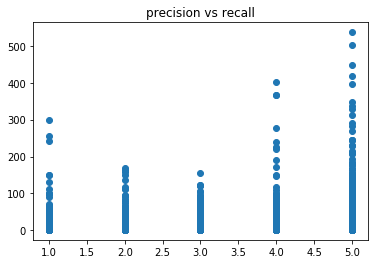

In [182]:
plt.scatter(plt_rating,plt_rate)
plt.title('precision vs recall')
plt.show()

In [258]:
### Validating dataset ###
helpful_valid = []
helpful_rate = []
for l in data[100000:200000]:
    if l['helpful']['outOf'] != 0:
        helpful_rate.append(l['helpful']['nHelpful'])# * 1.0 / l['helpful']['outOf'])
        words_num = len(l['reviewText'].split()) #split the words
            
        if l['reviewerID'] in user_helpful:
            a = user_helpful[l['reviewerID']]
            b = user_outOf[l['reviewerID']]
        else:
            a = 0
            b = 0
        if l['itemID'] in item_helpful:
            c = item_helpful[l['itemID']]
            d = item_outOf[l['itemID']]
        else:
            c = 0
            d = 0
        if b + d >= 40 and l['helpful']['outOf'] >= 40:
            percentage = (a + c) * 1.0 / (b + d)
            bias = (percentage - global_avg) * l['helpful']['outOf'] * 0.6
        else:
            bias = 0
            
        if words_num >= 200:
            feat_row = [1, l['helpful']['outOf'], words_num, l['rating']]
            feat = [theta_word[i]*feat_row[i] for i in range(0,len(feat_row))]
        #if l['rating'] >= 3.0:
        #    if 'price' in l:
        #        feat_row = [1, l['helpful']['outOf'], l['rating'], l['price']]
        #    else:
        #        feat_row = [1, l['helpful']['outOf'], l['rating'], 0]
        #    feat = [theta_rating[i]*feat_row[i] for i in range(0,len(feat_row))]
        elif 'price' in l and l['price'] >= 100:
            feat_row = [1, l['helpful']['outOf'], l['rating'], l['price']]
            feat = [theta_price[i]*feat_row[i] for i in range(0,len(feat_row))]
        elif l['helpful']['outOf'] >= 0 and l['unixReviewTime'] <= 1.35e9:
            feat_row = [1, l['helpful']['outOf'], l['rating'], l['unixReviewTime']]
            feat = [theta_time[i]*feat_row[i] for i in range(0,len(feat_row))]
        else:
            if 'price' in l:
                feat_row = [1, l['helpful']['outOf'], l['rating'], l['price']]
            else:
                feat_row = [1, l['helpful']['outOf'], l['rating'], 0]
            feat = [theta[i]*feat_row[i] for i in range(0,len(feat_row))]
            
        if l['helpful']['outOf'] == 1:
            helpful_valid.append(1)
        else:
            helpful_valid.append(sum(feat) + bias)

MAE = sum(abs(helpful_rate[i] - helpful_valid[i]) for i in range(0,len(helpful_rate))) * 1.0 / 100000#len(helpful_rate)
#print 'theta0 = ', theta[0], '  theta1 = ', theta[1], ' theta2 = ', theta[2], '  theta3 = ', theta[3], ' theta4 = ', theta[4]
print 'MAE = ', MAE

MAE =  0.171180325433


In [8]:
### Testing dataset and generating files ###
userItemHelpful = {}
helpfulBias = {}

for l in readGz("Assignment1/HW3/assignment1/test_Helpful.json.gz"):
    user, item = l['reviewerID'],l['itemID']
    if l['helpful']['outOf'] != 0:
        words_num = len(l['reviewText'].split()) #split the words
        if l['reviewerID'] in user_helpful:
            a = user_helpful[l['reviewerID']]
            b = user_outOf[l['reviewerID']]
        else:
            a = 0
            b = 0
        if l['itemID'] in item_helpful:
            c = item_helpful[l['itemID']]
            d = item_outOf[l['itemID']]
        else:
            c = 0
            d = 0
        if b + d >= 80 and l['helpful']['outOf'] >= 40:
            percentage = (a + c) * 1.0 / (b + d)
            #bias = (percentage - global_avg) * l['helpful']['outOf'] * 0.3
            bias = (percentage - global_avg) * l['helpful']['outOf'] * -0.4
        elif b + d <= 20 and b + d > 0:
            percentage = (a + c) * 1.0 / (b + d)
            bias = (percentage - global_avg) * l['helpful']['outOf'] * 0.3
        else:
            bias = 0
            
        if 'price' in l and l['price'] >= 100:
            if 'price' in l:
               feat_row = [1, l['helpful']['outOf'], l['rating'], l['price']]
            feat = [theta_price[i]*feat_row[i] for i in range(0,len(feat_row))]
        elif l['helpful']['outOf'] >= 5 and l['unixReviewTime'] <= 1.35e9:
            feat_row = [1, l['helpful']['outOf'], l['rating'], l['unixReviewTime']]
            feat = [theta_time[i]*feat_row[i] for i in range(0,len(feat_row))]
        else:
            if 'price' in l:
                feat_row = [1, l['helpful']['outOf'], l['rating'], l['price']]
            else:
                feat_row = [1, l['helpful']['outOf'], l['rating'], 0]
            feat = [theta[i]*feat_row[i] for i in range(0,len(feat_row))]
            
        userItemHelpful[user+item] = sum(feat)
        helpfulBias[user+item] = bias
    else:
        userItemHelpful[user+item] = 0
        helpfulBias[user+item] = 0
    #if l['reviewerID'] in user_helpful:
    #    testData.append([l['helpful']['outOf'], user_helpful[l['reviewerID']], user_outOf[l['reviewerID']]])

predictions = open("Assignment1/HW3/assignment1/predictions_Helpful.txt", 'w')
for l in open("Assignment1/HW3/assignment1/pairs_Helpful.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i, outOf = l.strip().split('-')
    outOf = int(outOf)
    if outOf == 1:
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(1) + '\n')
    elif round(userItemHelpful[u+i] + helpfulBias[u+i]) > outOf:
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf) + '\n')
    elif round(userItemHelpful[u+i] + helpfulBias[u+i]) < 0:
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(round(userItemHelpful[u+i])) + '\n')
    else:
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(int(round(userItemHelpful[u+i] + helpfulBias[u+i]))) + '\n')
            
predictions.close()

In [58]:
user = 'U306590119'
item = 'I726237697'
userItemHelpful[user+item]
helpfulBias[user+item]

-17.95057652131735